# After Using Previous Notebooks Use This Notebook to Make Predictions

In [1]:
# Imports --- All of this may not be vital


import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, f1_score, fbeta_score, recall_score, precision_score, confusion_matrix

from pprint import pprint
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *

# Homemade functions required
from data_prep_functions import *
from interpro_scraping import interpro_scraping_pandas

### Import Data

In [2]:
### import data used to train classifiers ###

plasma_total_data_names = pd.read_excel("data/"+'gt15_plasma_features_names_biopy_gravy_MD.xlsx', header=0, index_col=0)
# gt6_data = pd.read_excel("data/"+'gt6_plasma_features_names_biopy.xlsx', header=0, index_col=0)
csf_total_data_names = pd.read_excel("data/"+'gt15_csf_features_names_biopy_gravy_MD.xlsx', header=0,index_col=0)


## sort into names and features
## <class 'pandas.core.frame.DataFrame'>
features_plasma = plasma_total_data_names.copy()
features_plasma = features_plasma.drop(['Corona', 'Entry'], axis=1)
names_plasma = plasma_total_data_names['Corona'].copy()

features_csf = csf_total_data_names.copy()
features_csf = features_csf.drop(['Corona', 'Entry'], axis=1) 
names_csf = csf_total_data_names['Corona'].copy()

### create a merged set
features_plasma_labeled = features_plasma.copy()
features_csf_labeled = features_csf.copy()

features_plasma_labeled['phase_plasma'] = 1
features_csf_labeled['phase_plasma'] = 0

# Modified by Firebird 10/16/2025 to be able to use with python 3.12 
#features_merged = features_plasma_labeled.append(features_csf_labeled, ignore_index=True)
#names_merged = names_plasma.append(names_csf, ignore_index=True)

features_merged = pd.concat([features_plasma_labeled, features_csf_labeled], ignore_index=True)
names_merged = pd.concat([names_plasma, names_csf], ignore_index=True)

# QC test prints
#print(features_plasma_labeled.shape, features_csf_labeled.shape, features_merged.shape)
print(features_merged)#["phase_plasma"] = 1)

# set with no phase labeling names are identical to names merged
features_merged_naive = features_merged.drop(['phase_plasma'], axis=1)

# print(plasma_total_data_names.shape, csf_total_data_names.shape, features_test.shape) ## in case you need to see shapes


## there is a known error here, sometimes there is an Unnamed column just drop it code is available in a 
#lower cell (scaling cell), its a holdover from two merged set

# tf_data = features_merged_naive.copy()
# tf_data['names'] = names_merged.copy()
# tf_data.to_excel('data_for_tensorflow.xlsx')


                                         Protein names  frac_aa_A  frac_aa_C  \
0                                        Serum albumin   0.103448   0.057471   
1    Haptoglobin (Zonulin) [Cleaved into: Haptoglob...   0.073892   0.029557   
2    Immunoglobulin kappa constant (Ig kappa chain ...   0.065421   0.028037   
3    Immunoglobulin heavy constant gamma 1 (Ig gamm...   0.039394   0.027273   
4    Serotransferrin (Transferrin) (Beta-1 metal-bi...   0.087393   0.057307   
..                                                 ...        ...        ...   
169  Hemoglobin subunit beta (Beta-globin) (Hemoglo...   0.102041   0.013605   
170  Haptoglobin (Zonulin) [Cleaved into: Haptoglob...   0.073892   0.029557   
171  Immunoglobulin heavy constant alpha 1 (Ig alph...   0.067989   0.042493   
172  Immunoglobulin lambda constant 7 (Ig lambda-7 ...   0.103774   0.028302   
173  Complement C4-A (Acidic complement C4) (C3 and...   0.078555   0.016055   

     frac_aa_D  frac_aa_E  frac_aa_F  f

In [3]:
#### revisions 

total_data_for_reductions = features_merged_naive.copy()
total_data_for_reductions['Corona'] = names_merged

total_data_reduced = total_data_for_reductions.drop_duplicates(subset=['Protein names'])
total_data_reduced.shape

names_reduced = total_data_reduced['Corona']
features_reduced = total_data_reduced.drop('Corona', axis=1)
reduced_protein_names = features_reduced['Protein names']

In [4]:
## Use this space to import test data ### 


#features_test = pd.read_excel("data/"+'proteins_selected_for_testing_complete_updated.xlsx', header=0, index_col = 0)

# uncomment below for large verification runs with labels

features_test = pd.read_excel("data/"+'pnp_csf_features_names_biopy_gravy_MD.xlsx', header=0, index_col = 0)
uuu = list(features_test.columns)
print(uuu, "\n", len(uuu))
# MOVED A LINE TO SCALING CELL FOR ORDER OF OPERATIONS
y_test_test = features_test['Corona'].copy()

# THIS LINE MOVED TO SCALING CELL FOR ORDER OF OPERATIONS
# THIS WHILE CODE NEEDS TO BE REFACTORED TO MAKE SENSE, 
# TOO MANY COPIES OF DATAFRAMES FLOATING AROUND AND ILOGICAL ORDER ISSUES
# 10/16/2025 Firebird
df_local_protein_names_classify = features_test['Protein names'] #.copy()

features_test = features_test.drop(['Protein names', 'mass'], axis=1)


['Corona', 'Protein names', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_var', 'flexibility_max', 'flexibility_min', 'flexibility_median', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'length', 'mass', 'Unnamed: 0', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_median', 'rsa_std', 'asa_sum', 'fraction_total_exposed_A', 'fraction_total_exposed_C', 'fraction_total_exposed_D', 'fraction_t

In [5]:
### if were not going to be using NETSURFP 

features_for_prediction = pd.read_excel("data/"+'proteins_selected_for_testing_complete_MD.xlsx', header=0, index_col = 0)
# print(list(features_for_prediction.columns))
# subset_features = features_merged_naive[list(features_for_prediction.columns)]

### Scale Data To Make it Work Well

In [6]:
scaler = MinMaxScaler()
total_data = features_merged_naive.copy()  ## for a regular netsurfp included case
# total_data = subset_features.copy() ### for a subset case --- use this one
total_data = total_data.fillna(0)
total_data_with_names = total_data.copy()
total_data = total_data.drop(['Protein names', 'mass' ], axis=1)
scaler = scaler.fit(total_data)
scaled_df = pd.DataFrame(scaler.transform(total_data), columns=total_data.columns)
#scaled_df.to_csv("02-intermediate_results/scaled_full_data.csv")
#print(scaled_df.shape)

scaled_df_phase = scaled_df.copy()

# Add the "phase_plasma" column back to the scaled dataframe
scaled_df_phase['phase_plasma'] = features_merged['phase_plasma'].copy()

plasma_data = scaled_df_phase[scaled_df_phase.phase_plasma==1]
plasma_data = plasma_data.drop(['phase_plasma'], axis=1)
scaled_df_plasma = plasma_data #pd.DataFrame(scaler.transform(plasma_data), columns=plasma_data.columns)

csf_data = scaled_df_phase[scaled_df_phase.phase_plasma==0]
csf_data = csf_data.drop(['phase_plasma'], axis=1)
scaled_df_csf = csf_data #pd.DataFrame(scaler.transform(csf_data), columns=csf_data.columns)

### UNCOMMENT this section for a REGULAR RUN
#features = features_merged_naive.copy()  # change the dataframe that you want to use here
features_test = features_test.fillna(0)
features_test_names = features_test.copy()

#print(features_test.axes)
#features_test = features_test.drop(['Protein names', 'mass'], axis=1) #,'entry'
features_test = features_test.drop(['Corona', 'Unnamed: 0', 'Entry'], axis=1) #,'entry'
scaled_test_df = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)
#print(np.min(scaled_df))

# features_reduced = features_reduced.drop(['Protein names'], axis=1)
# scaled_reduced_df = pd.DataFrame(scaler.transform(features_reduced), columns=features_reduced.columns)


# scaled_df = scaled_df.drop(['Unnamed: 0.1'], axis=1)
# scaled_df_phase = scaled_df_phase.drop(['Unnamed: 0.1'], axis=1)
# scaled_test_df = scaled_test_df.drop(['Unnamed: 0.1'], axis=1)


In [7]:
print(len(list(scaled_df.columns)))

92


In [8]:
gt6_data = pd.read_excel("data/"+'pnp_plasma_features_names_biopy_gravy_MD.xlsx', header=0, index_col=0)
features_gt6 = gt6_data.copy()
features_gt6 = features_gt6.drop(['Corona'], axis=1)
names_gt6 = gt6_data['Corona'].copy()

features_gt6_combined = pd.concat([features_merged_naive, features_gt6], ignore_index=True)
names_gt6_combined = pd.concat([names_merged, names_gt6], ignore_index=True)
features_gt6_combined = features_gt6_combined.drop(columns=['Protein names', 'mass', 'Unnamed: 0', 'Entry'])
total_data_col_drop = total_data.copy()

# scaler = scaler.fit(features_gt6_combined)
scaled_df_gt6 = pd.DataFrame(scaler.transform(features_gt6_combined), columns=total_data_col_drop.columns)

### Data to be Put into classifier

In [9]:
### Data put into classifier and classified
s_df = scaled_df#.drop(['Unnamed: 0.1', 'mass' ], axis=1)

# WHY DOES THIS LINE EXIST?
scaled_test_df = scaled_test_df#.drop(['Unnamed: 0.1', 'mass'], axis=1)

df_local_features_train = s_df.copy()
# df_local_protein_names_train = features_merged['Protein names'].copy()#reduced_protein_names.copy()
df_local_names = names_merged.copy()

df_local_features_classify = scaled_test_df.copy() #.drop(['Unnamed: 0.1'], axis=1)

# Moved to a previous cell to make sense of scaling order
#df_local_protein_names_classify = features_test_names['Protein names'] #.copy()

### to keep some things kosher later
df_local_features_train_copy = s_df.copy()
df_local_names_copy = names_merged.copy()
df_local_features_classify_copy = df_local_features_classify.copy()
df_local_protein_names_classify_copy = df_local_protein_names_classify.copy()

# Classifier

In [10]:
k_fold_splits = 100
predictions = pd.DataFrame()

X_new = SelectKBest(f_classif, k=92).fit_transform(df_local_features_train.copy(), df_local_names.copy()) #X_train_set.values #
df_local_features_train = pd.DataFrame(X_new.copy())#df_local_features_train.copy() #pd.DataFrame(X_new.copy()) #scaled_df.copy()

rndm_ste=2016
feature_imp = pd.DataFrame(columns=list(df_local_features_train.columns))
first_frame = True
correctness_frame = pd.DataFrame()
metrics_frame = pd.DataFrame()

set_size_adjust = (scaled_df.shape[0]/scaled_df_plasma.shape[0]) *.1 # used to retain the same number of samples in the test set, replace test_size with it if using
# #split up our data
i = 0

sss = StratifiedShuffleSplit(n_splits=k_fold_splits, test_size=0.1, random_state=rndm_ste)

for train_index, test_index in sss.split(df_local_features_train, df_local_names): # comment our if doing cross fluid
# for train_index, test_index in sss.split(scaled_df_plasma, names_plasma): # use for cross fluid tests, verify correct dataset placed here
    X_train = df_local_features_train.iloc[train_index] # remove subsetting for cross fluid tests
    X_test = df_local_features_train.iloc[test_index] # change dataframe for cross fluid tests
    y_train = df_local_names.iloc[train_index] # remove subsetting for cross fluid tests
    y_test = df_local_names.iloc[test_index] # change dataframe for cross fluid tests
   
    # Create and Train
    rfc=RandomForestClassifier(criterion='entropy', min_impurity_decrease = 0.02,  min_samples_split=2, max_depth = 10, max_features = 'sqrt',
     n_jobs=-1, ccp_alpha=0.01, random_state=rndm_ste, n_estimators=700) 
 
    
    #sme = SMOTE(random_state=rndm_ste, sampling_strategy=0.7, n_jobs=-1, k_neighbors=12)
    sme = SMOTE(random_state=rndm_ste, sampling_strategy=0.7, k_neighbors=12)

    X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)
    # X_train_oversampled, y_train_oversampled = X_train, y_train # can be used to pass smote if needed for an experiment
    rfc.fit(X_train_oversampled,y_train_oversampled)


    

    if first_frame:  # Initialize 
        first_frame = False  # Don't Come back Here
        
        datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
        
        correctness_frame = pd.DataFrame(data=datadict)
        correctness_frame['round'] = i

        metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
        'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
        'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
        
        metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
        metrics_frame['Round'] = i

        # can be used if you want to track prediction during shuffle split - saves in another cell
        predictions = pd.DataFrame()
        predictions['Protein Name'] = df_local_protein_names_classify
        predictions['In Corona Probability'] = rfc.predict_proba(df_local_features_classify)[:, 1]
        predictions['Round'] = i
        predictions['Test Accuracy'] = metrics_dict['Accuracy']
        predictions['Test Recall'] = metrics_dict['Recall']
        predictions['Test Precision'] = metrics_dict['Precision']
        predictions['Test AUC'] = metrics_dict['AUC']

        
    else:
        datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
        revolve_frame = pd.DataFrame(data=datadict)
        revolve_frame['round'] = i
        #correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
        correctness_frame = pd.concat([correctness_frame, revolve_frame], ignore_index=True)

        metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
        'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
        'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
        metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
        metrics_revolve_frame['Round'] = i
        #metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
        metrics_frame = pd.concat([metrics_frame, metrics_revolve_frame], ignore_index=True)

        # can be used if you want to track prediction during shuffle split - saves in another cell
        pred_rev = pd.DataFrame()
        pred_rev['Protein Name'] = df_local_protein_names_classify
        pred_rev['In Corona Probability'] = rfc.predict_proba(df_local_features_classify)[:, 1]
        pred_rev['Round'] = i
        pred_rev['Test Accuracy'] = metrics_dict['Accuracy']
        pred_rev['Test Recall'] = metrics_dict['Recall']
        pred_rev['Test Precision'] = metrics_dict['Precision']
        pred_rev['Test AUC'] = metrics_dict['AUC']

        #predictions = predictions.append(pred_rev, ignore_index=True)
        predictions = pd.concat([predictions, pred_rev], ignore_index=True)


    
    feature_imp.loc[i] = pd.Series(rfc.feature_importances_,index=list(df_local_features_train.columns))
    
    i += 1

/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/randhal/.local/lib/

In [11]:
# displays results
metrics_frame.mean()

AUC           0.736458
Accuracy      0.756667
Recall        0.580000
Precision     0.664510
F1            0.598842
Round        49.500000
dtype: float64

In [12]:
X_new_data = pd.read_excel("new_data_2025/data_100_prot_MD.xlsx", header=0, index_col=0)
y_new_data = X_new_data['Corona'].copy()
X_new_data = X_new_data.drop(['Protein names', 'mass', 'Corona'], axis=1)
X_new_data = pd.DataFrame(scaler.transform(X_new_data), columns=X_new_data.columns)


In [13]:
# Assuming you have the following dataframes for the new prediction:
# X_new_data: DataFrame of features (must be the 91 selected features)
# y_new_data: Series/Array of true labels

# --- 1. Make Predictions using the Last Trained Model (rfc) ---
# Get predicted class (0 or 1)
y_pred_new = rfc.predict(X_new_data)

# Get prediction probabilities for the positive class (used for AUC)
y_proba_new = rfc.predict_proba(X_new_data)[:, 1]

# --- 2. Compute Performance Metrics ---
from sklearn import metrics
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score

# Area Under the ROC Curve
new_auc = roc_auc_score(y_new_data, y_proba_new)

# Recall (Sensitivity)
new_recall = recall_score(y_new_data, y_pred_new)

# Precision (Positive Predictive Value)
new_precision = precision_score(y_new_data, y_pred_new)

# F1-Score (Harmonic mean of Precision and Recall)
new_f1 = f1_score(y_new_data, y_pred_new)

# You can also get the overall Accuracy
new_accuracy = rfc.score(X_new_data, y_new_data)

# --- 3. Display Results ---
print(f"Metrics on New Data:")
print(f"  AUC:       {new_auc:.4f}")
print(f"  Recall:    {new_recall:.4f}")
print(f"  Precision: {new_precision:.4f}")
print(f"  F1-Score:  {new_f1:.4f}")
print(f"  Accuracy:  {new_accuracy:.4f}")

# --- 4. Visualize the Confusion Matrix (Optional but Recommended) ---
# This shows the breakdown of correct and incorrect predictions.
conf_matrix = metrics.confusion_matrix(y_new_data, y_pred_new)
print("\nConfusion Matrix:")
print(conf_matrix)

/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Metrics on New Data:
  AUC:       0.6495
  Recall:    0.3814
  Precision: 1.0000
  F1-Score:  0.5522
  Accuracy:  0.4000

Confusion Matrix:
[[ 3  0]
 [60 37]]


In [20]:
# Improvement

8/32*100

25.0

## Collect Revolving Predictions (if applicable)

This is a feature that is not used in the manuscript 

In [14]:
unique_names = []
for i in predictions['Protein Name']:
    if i not in unique_names:
        unique_names.append(i)

protein_avg_predictions = pd.DataFrame()
counter = 0
for i in unique_names:
    avg_df = predictions[predictions['Protein Name'] == i]

    if counter == 0:
        protein_avg_predictions = pd.DataFrame([i, round(avg_df['In Corona Probability'].mean(), 3), round(confidence_interval(avg_df['In Corona Probability']), 3)], index=['Protein Name', 'Average In Corona Probability', '95 Percent Confidence Interval']).transpose()
        
    else:
        pap_df = pd.DataFrame([i, round(avg_df['In Corona Probability'].mean(), 3), round(confidence_interval(avg_df['In Corona Probability']), 3)], index=['Protein Name', 'Average In Corona Probability', '95 Percent Confidence Interval']).transpose()
        #protein_avg_predictions = protein_avg_predictions.append(pap_df, ignore_index=True)
        protein_avg_predictions = pd.concat([protein_avg_predictions, pap_df], ignore_index=True)  
    
    counter += 1

protein_avg_predictions

,Protein Name,Average In Corona Probability,95 Percent Confidence Interval
0,Serum albumin,0.073,0.005
1,Transthyretin (ATTR) (Prealbumin) (TBPA),0.7,0.015
2,Alpha-1-antitrypsin (Alpha-1 protease inhibito...,0.364,0.021
3,Prostaglandin-H2 D-isomerase (EC 5.3.99.2) (Be...,0.59,0.021
4,Serotransferrin (Transferrin) (Beta-1 metal-bi...,0.413,0.019
...,...,...,...
57,Hemoglobin subunit beta (Beta-globin) (Hemoglo...,0.15,0.009
58,Haptoglobin (Zonulin) [Cleaved into: Haptoglob...,0.403,0.018
59,Immunoglobulin heavy constant alpha 1 (Ig alph...,0.089,0.006
60,Immunoglobulin lambda constant 7 (Ig lambda-7 ...,0.107,0.006


[np.float64(0.7719298245614035), np.float64(0.8110236220472441), np.float64(0.8312655086848635), np.float64(0.8095238095238095), np.float64(0.7313432835820896), np.float64(0.5104895104895105), np.float64(0.7515527950310559), np.float64(0.6306306306306306), np.float64(0.6666666666666666), np.float64(0.9411764705882353)] ['[0.0, 0.1)', '[0.1, 0.2)', '[0.2, 0.3)', '[0.3, 0.4)', '[0.4, 0.5)', '[0.5, 0.6)', '[0.6, 0.7)', '[0.7, 0.8)', '[0.8, 0.9)', '[0.9, 1.0)']


/tmp/ipykernel_880746/3706763815.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=bar_names, y=pct_correct, ci=None)


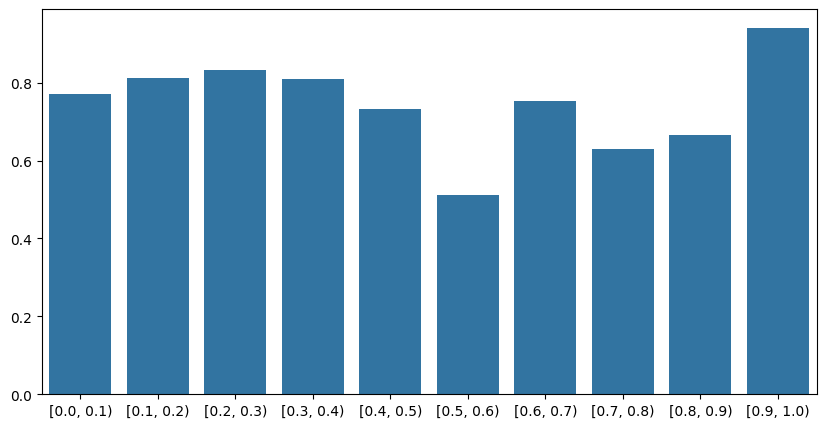

In [15]:
pct_correct = []


for i in range(10):
    subset = correctness_frame[correctness_frame.probability>= i *.1]
    subset = subset[subset.probability <(i+1)*.1]

#     subset = correctness_frame[correctness_frame.probability>=i]
    subset['correct'] = subset['true'] == subset['estimate']
    pct_correct.append(subset.correct.sum() / subset.shape[0])
    
bar_names = ['[' + str(np.around((i-1)*.1, decimals=1)) + ', ' + str(np.around((i)*.1, decimals=1)) +')'  for i in range(1,11)]
print(pct_correct, bar_names)#, steps)
#subset
fig= plt.figure(figsize=(10,5))
sns.barplot(x=bar_names, y=pct_correct, ci=None)

plt.show()

In [16]:
overall_probability_accuracy = pd.DataFrame([pct_correct], columns=bar_names)
#metrics_frame = metrics_frame.append(pd.DataFrame({"AUC":[metrics_frame.AUC.mean(), confidence_interval(metrics_frame.AUC)], "Accuracy":[metrics_frame.Accuracy.mean(), confidence_interval(metrics_frame.Accuracy)], "Precision":[metrics_frame.Precision.mean(), confidence_interval(metrics_frame.Precision)],'Round':['Average', '.95 CI'], 'Recall':[metrics_frame.Recall.mean(), confidence_interval(metrics_frame.Recall)], 'F1':[metrics_frame.F1.mean(), confidence_interval(metrics_frame.F1)]}), ignore_index=True)
metrics_frame = pd.concat([metrics_frame, pd.DataFrame({"AUC":[metrics_frame.AUC.mean(), confidence_interval(metrics_frame.AUC)], "Accuracy":[metrics_frame.Accuracy.mean(), confidence_interval(metrics_frame.Accuracy)], "Precision":[metrics_frame.Precision.mean(), confidence_interval(metrics_frame.Precision)],'Round':['Average', '.95 CI'], 'Recall':[metrics_frame.Recall.mean(), confidence_interval(metrics_frame.Recall)], 'F1':[metrics_frame.F1.mean(), confidence_interval(metrics_frame.F1)]})], ignore_index=True)

# Make Predictions Using the Entire Saved Dataset

Ensure that you are using the right k values and data files here

In [17]:
X_train_total = df_local_features_train_copy.copy() #df_local_features_train #df_local_features_train_copy
y_train_total = df_local_names #df_local_names#df_local_names_copy
rndm_ste = 2016
k_best = SelectKBest(f_classif, k=91)
fit = k_best.fit(X_train_total, y_train_total)
X_new = fit.transform(X_train_total)
 #X_train_set.values #
X_train_total = pd.DataFrame(X_new.copy())

rfc=RandomForestClassifier(criterion='entropy', min_impurity_decrease = 0.02,  min_samples_split=2, max_depth = 10, max_features = 'sqrt',
     n_jobs=-1, ccp_alpha=0.01, random_state=rndm_ste, n_estimators=700)

#sme = SMOTE(random_state=2016, sampling_strategy=0.7, n_jobs=-1, k_neighbors=12)
sme = SMOTE(random_state=2016, sampling_strategy=0.7, k_neighbors=12)


X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train_total, y_train_total)
rfc.fit(X_train_oversampled,y_train_oversampled)


total_train_test = pd.DataFrame()
total_train_test['Protein Name'] = df_local_protein_names_classify_copy
# pd.DataFrame(fit.transform(df_local_features_classify_copy))
# total_train_test['In Corona Probability'] = rfc.predict_proba(df_local_features_classify_copy)[:, 1]

print(len(k_best.get_support()), df_local_features_train_copy.shape)
total_train_test['In Corona Probability'] = rfc.predict_proba(pd.DataFrame(df_local_features_classify_copy.loc[:,k_best.get_support()]))[:, 1]

92 (174, 92)


/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [18]:
# print weights for table s2
pd.Series(rfc.feature_importances_,index=list(df_local_features_train_copy.columns)).sort_values(ascending=False).to_excel('revisions_data_2/table_s2_weights.xlsx')

ValueError: Length of values (91) does not match length of index (92)

In [ ]:
# for full dataset testing scoire
y_test_score = y_test_test 
X_score = df_local_features_classify_copy.loc[:,k_best.get_support()]

results_dict = {'AUC':metrics.roc_auc_score(y_test_score, rfc.predict_proba(X_score)[:, 1]),
        'Accuracy':rfc.score(X_score, y_test_score), 'Recall':recall_score(y_test_score, rfc.predict(X_score)), 
        'Precision':precision_score(y_test_score, rfc.predict(X_score)), 'F1':f1_score(y_test_score, rfc.predict(X_score))}

pprint(results_dict)
count_proxy  = total_train_test.copy()
count_proxy['In Corona'] = count_proxy['In Corona Probability'] >= 0.5 


/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


{'AUC': 0.8427083333333334,
 'Accuracy': 0.7903225806451613,
 'F1': 0.7547169811320755,
 'Precision': 0.9523809523809523,
 'Recall': 0.625}


/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/randhal/.local/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# display results
total_train_test 

,Protein Name,In Corona Probability
0,Serum albumin,0.064075
1,Transthyretin (ATTR) (Prealbumin) (TBPA),0.685375
2,Alpha-1-antitrypsin (Alpha-1 protease inhibito...,0.329636
3,Prostaglandin-H2 D-isomerase (EC 5.3.99.2) (Be...,0.567345
4,Serotransferrin (Transferrin) (Beta-1 metal-bi...,0.382192
...,...,...
57,Hemoglobin subunit beta (Beta-globin) (Hemoglo...,0.128105
58,Haptoglobin (Zonulin) [Cleaved into: Haptoglob...,0.461901
59,Immunoglobulin heavy constant alpha 1 (Ig alph...,0.079813
60,Immunoglobulin lambda constant 7 (Ig lambda-7 ...,0.093418


## Writes all Prediction Data (Including Revolving Predictions Data)

In [ ]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('2025_12_15_predictions_selected_proteins_gt6_MD.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.

predictions.to_excel(writer, sheet_name='Round Based Prediction')
metrics_frame.to_excel(writer, sheet_name='Classifier Round Metrics')
protein_avg_predictions.to_excel(writer, sheet_name='Protein Average Predictions')
overall_probability_accuracy.to_excel(writer, sheet_name='Overall Probability Accuracy')
total_train_test.to_excel(writer, sheet_name='Total Set Used in Prediction')


# Close the Pandas Excel writer and output the Excel file.
writer.close()

In [ ]:


count_proxy  = total_train_test.copy()
count_proxy['In Corona'] = count_proxy['In Corona Probability'] >= 0.5 
print(count_proxy['In Corona'].sum())

21
